<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/esempio3_fit_Fe_LEMON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#
# inzializzazione delle funzioni (librerie) usate nel notebook
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import chisquare
plt.rc('font', size = 14, family ='Sans-Serif')

# LEMON
phKev       = 2045.15/5.9
pixelscale  = 0.125 
x_resolution = y_resolution = 2048
xyscale = x_resolution/576
rescale_pixelscale = xyscale*pixelscale

In [0]:
#
# carica i dati dal file
#
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]

C_file = 'https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/dbscan_run2359_cmin_0_cmax_300_rescale_576_nsigma_1.5_ev_1000_ped_2358.txt'
df = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.

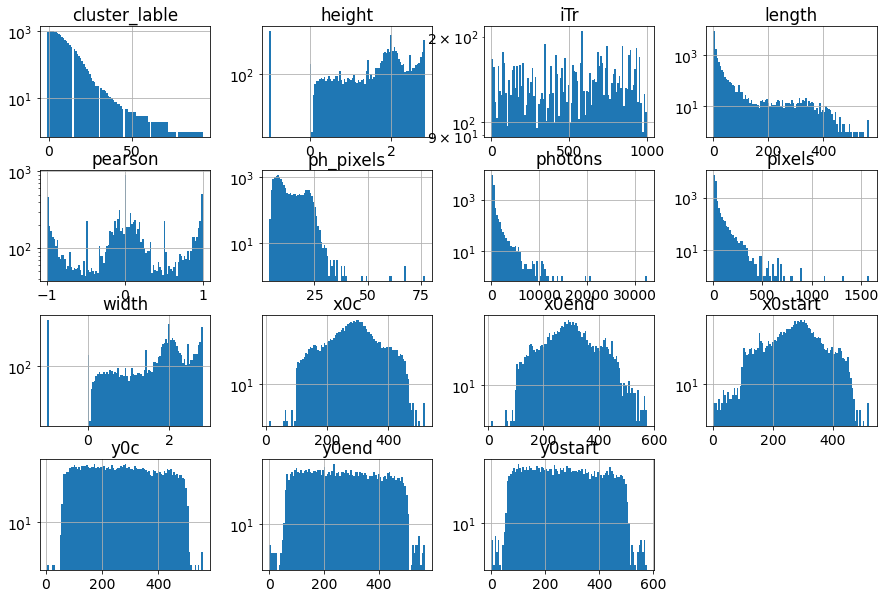

In [4]:
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

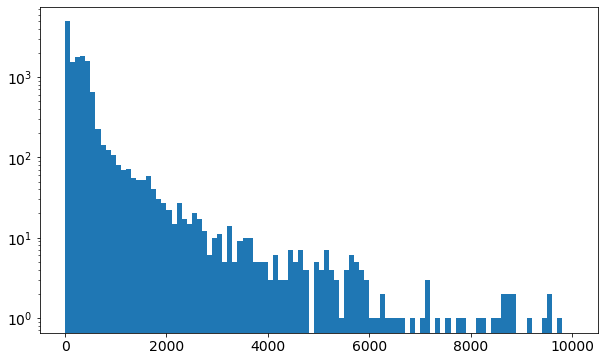

In [25]:
#
# Visualizziamo i fotoni
#
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df['photons'], 100, range=(0,10000))
# ax.set_xlim(0,30)
# ax.set_ylim(0,12)
# ax.set_xlabel('Superficie [$km^2$]')
# ax.set_ylabel(r'Popolazione [$\times 10^6$]')
# plt.title('Densità Popolazione Italiana')
# for k in range(x.size):
#   plt.annotate(df['Regione'][k], (x[k],y[k]),fontsize=12)
# plt.minorticks_on()
# plt.grid()
# plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
#                grid_color='grey', grid_alpha=0.5)
ax.set_yscale('log')
plt.show()

Fidical Ellips: 100.00, 120.00 [mm]


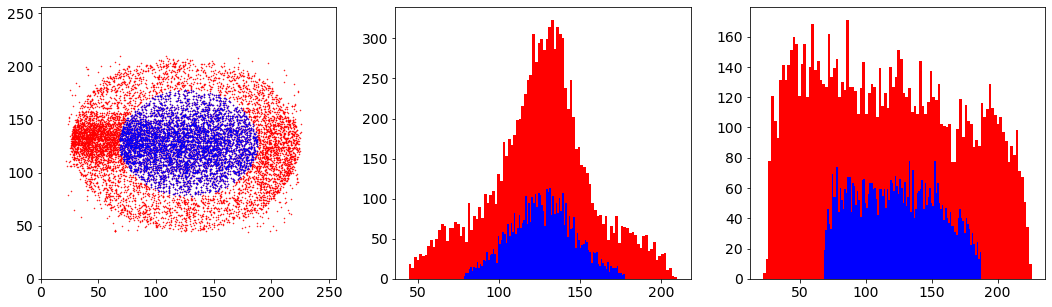

In [7]:
pd.set_option('mode.chained_assignment', None)
dfc = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

# Normalization

dfc['photons']  =dfc['photons']*xyscale*xyscale
dfc['length']   =dfc['length']*rescale_pixelscale
dfc['x0c']      =dfc['x0c']*rescale_pixelscale
dfc['y0c']      =dfc['y0c']*rescale_pixelscale

# fiducializzation

DX = 0 
DY = 0
a = 100. # mm 
b = 120. # mm

a0 = a*0.5
b0 = b*0.5
#################################################


print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

d0 = x_resolution*pixelscale/2

fig, ax = plt.subplots(1,3, figsize=(18, 5))

y = dfc['y0c']
x = dfc['x0c']
x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
ax[0].plot(y, x, 'r.', markersize=1)
ax[0].plot(y1, x1, 'b.', markersize=1)
ax[0].set_xlim(0,256)
ax[0].set_ylim(0,256)
ax[1].hist(x, color='r',bins=100)
ax[1].hist(x1, color='b',bins=100)
ax[2].hist(y, color='r',bins=100)
ax[2].hist(y1, color='b',bins=100)
plt.show()

dfc = dfc[((dfc['x0c']-d0)**2/a0**2 + (dfc['y0c']-d0)**2/b0**2 )< 1]

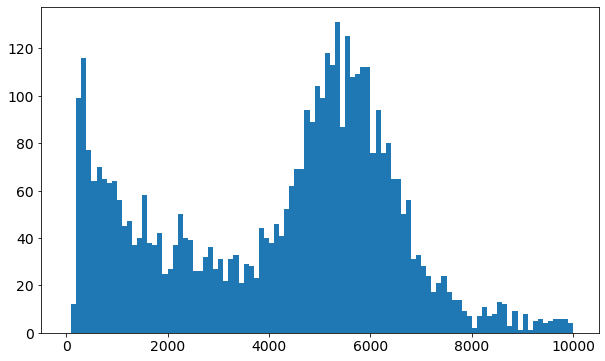

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(dfc['photons'], 100, range=(0,10000))
plt.show()

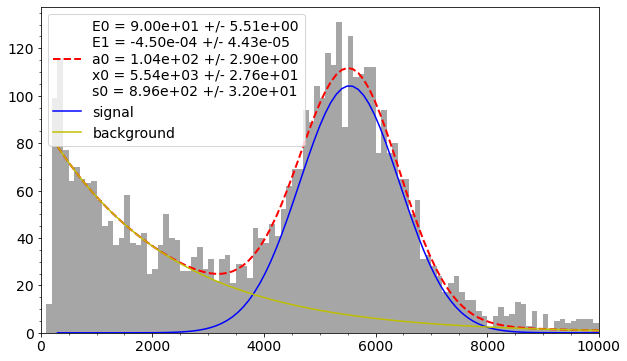

In [27]:
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data,ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh, 
                            p0=(E0, E1, a0, x0, s0))    
    #print ("Params: ", popt) 
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' % 
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax


bins = 100

fig, ax = plt.subplots(figsize=(10,6))
myExpG(dfc['photons'], ax, 300., 10000., 100, 10000., -0.001, 100., 7000., 300.)
ax.hist(dfc['photons'], bins=100, range=(0,10000.), color='gray', alpha=0.7)
ax.set_xlim(0,10000)

plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()